In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

In [2]:
# read in data
field_data = pd.read_csv('HABs2022_FieldData.csv')
mastersheet = pd.read_csv('HABs2022_SampleMastersheet.csv')

# explore data
field_data.head()

,Sample_ID,Location,Site_Name,Site_ID,Lat,Long,Sampling_Date,Sampling_Time,Timezone,USGS_siteno,...,TAL PC ug/L,Wiper Position volt,B-G Algae mg/L,Nitrate mg/L,fCHL,Secchi Depth,BGA-PC ug/L,Phyco-cyanin ug/L,Discharge (cu.ft/s),Notes
0,RPT_01,"Upper Klamath Lake, OR (UKL)",Rattlesnake Point,RPT,42.344360,-121.857150,7/5/2022,8:55:00 AM,PDT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Partly sunny, no wind. Averaged from 2 samples..."
1,WRM,"Upper Klamath Lake, OR (UKL)",Williamson River Mouth,WRM,42.463540,-121.958830,7/5/2022,9:30:00 AM,PDT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Partly sunny, no wind. Averaged from 2 samples..."
2,PB,"Upper Klamath Lake, OR (UKL)",Pelican Bay,PB,42.457420,-122.071390,7/5/2022,10:35:00 AM,PDT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Partly sunny, no wind. Averaged from 2 samples..."
3,RPT_02,"Upper Klamath Lake, OR (UKL)",Rattlesnake Point,RPT,42.344304,-121.858196,7/25/2022,9:50:00 AM,PDT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Barometric Pressure taken from office not fiel...
4,HB_01,"Upper Klamath Lake, OR (UKL)",Howard Bay,HB,42.315390,-121.941946,7/25/2022,9:20:00 AM,PDT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Barometric Pressure taken from office not fiel...


In [3]:
mastersheet.head()

,Sample_ID,Location,Instrument,Spectrum_ID_Algal,Spectrum_ID_Water,Morphological ID,Morphologist,Objective
0,RPT_01,"Upper Klamath Lake, OR (UKL)",Resonon Pika XC2,Spectrum_0001_Algal,Spectrum_0001_Water,Gloeotrichia,Sarah Spaulding,20x
1,RPT_01,"Upper Klamath Lake, OR (UKL)",Resonon Pika XC2,Spectrum_0002_Algal,Spectrum_0002_Water,Aphanizomenon,Sarah Spaulding,20x
2,RPT_01,"Upper Klamath Lake, OR (UKL)",Resonon Pika XC2,Spectrum_0003_Algal,Spectrum_0003_Water,Dolichospermum,Sarah Spaulding,20x
3,RPT_01,"Upper Klamath Lake, OR (UKL)",Resonon Pika XC2,Spectrum_0004_Algal,Spectrum_0004_Water,Gloeotrichia,Sarah Spaulding,20x
4,RPT_01,"Upper Klamath Lake, OR (UKL)",Resonon Pika XC2,Spectrum_0005_Algal,Spectrum_0005_Water,Aphanizomenon,Sarah Spaulding,20x


In [4]:
# remove spaces in column names
mastersheet.rename(columns={'Morphological ID': 'Morphological_ID'}, inplace=True)


In [5]:
# merge datasets by sample ID
# includes morphological ID, latitude, longitude, and average temperature
algae_merged = duckdb.sql("""SELECT mastersheet.Sample_ID, mastersheet.Morphological_ID, field_data.Lat, field_data.Long, field_data.Sampling_Date AS Date, field_data.Sampling_Time as Time, field_data.Avg_WaterTemp_degC AS avg_temp
                             FROM mastersheet LEFT JOIN field_data ON mastersheet.Sample_ID = field_data.Sample_ID""").df()

In [6]:
algae_merged['Date'] = pd.to_datetime(algae_merged['Date'], format='%m/%d/%Y')
algae_merged['Time'] = pd.to_datetime(algae_merged['Time'], format='%I:%M:%S %p')
algae_merged.sort_values(by='Morphological_ID', ascending=True, inplace=True)

In [7]:
harmful_algae = ['Aphanizomenon', 'Dolichospermum', 'Microcystis', 'Oscillatoria', 'Gloeotrichia', 'Phormidium']
algae_merged['harmful'] = algae_merged['Morphological_ID'].isin(harmful_algae)



In [8]:
algae_merged.describe().T

,count,mean,min,25%,50%,75%,max,std
Lat,314.0,42.140546,38.4782,39.35292,42.378403,44.146269,45.190336,2.216766
Long,314.0,-110.931203,-122.791233,-122.246272,-121.85715,-107.10744,-75.33028,17.508986
Date,314,2022-07-23 13:40:53.503184640,2022-06-08 00:00:00,2022-07-05 00:00:00,2022-07-20 00:00:00,2022-08-09 00:00:00,2022-08-24 00:00:00,NaN
Time,314,1900-01-01 11:50:45.477707008,1900-01-01 08:10:00,1900-01-01 10:05:00,1900-01-01 10:50:00,1900-01-01 13:15:00,1900-01-01 18:52:00,NaN
avg_temp,314.0,20.370955,9.9,14.475,21.505,24.8,31.18,6.348483


In [9]:
algae_merged.head(10)

,Sample_ID,Morphological_ID,Lat,Long,Date,Time,avg_temp,harmful
61,RPT_02,Aphanizomenon,42.344304,-121.858196,2022-07-25,1900-01-01 09:50:00,21.04,True
101,LL,Aphanizomenon,42.378403,-88.133460,2022-07-13,1900-01-01 10:50:00,25.12,True
36,HB_01,Aphanizomenon,42.315390,-121.941946,2022-07-25,1900-01-01 09:20:00,21.27,True
37,HB_01,Aphanizomenon,42.315390,-121.941946,2022-07-25,1900-01-01 09:20:00,21.27,True
39,HB_01,Aphanizomenon,42.315390,-121.941946,2022-07-25,1900-01-01 09:20:00,21.27,True
40,HB_01,Aphanizomenon,42.315390,-121.941946,2022-07-25,1900-01-01 09:20:00,21.27,True
41,HB_01,Aphanizomenon,42.315390,-121.941946,2022-07-25,1900-01-01 09:20:00,21.27,True
42,HB_01,Aphanizomenon,42.315390,-121.941946,2022-07-25,1900-01-01 09:20:00,21.27,True
43,HB_01,Aphanizomenon,42.315390,-121.941946,2022-07-25,1900-01-01 09:20:00,21.27,True
44,HB_01,Aphanizomenon,42.315390,-121.941946,2022-07-25,1900-01-01 09:20:00,21.27,True


In [10]:
algae_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 314 entries, 61 to 259
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Sample_ID         314 non-null    object        
 1   Morphological_ID  314 non-null    object        
 2   Lat               314 non-null    float64       
 3   Long              314 non-null    float64       
 4   Date              314 non-null    datetime64[ns]
 5   Time              314 non-null    datetime64[ns]
 6   avg_temp          314 non-null    float64       
 7   harmful           314 non-null    bool          
dtypes: bool(1), datetime64[ns](2), float64(3), object(2)
memory usage: 19.9+ KB


In [11]:
algae_counts = algae_merged.groupby('Morphological_ID', as_index=False).agg(
    count=('Morphological_ID', 'count')
)
algae_counts

,Morphological_ID,count
0,Aphanizomenon,50
1,Botryococcus,3
2,Cladophora,6
3,Closterium,2
4,Cymbella,2
5,Dolichospermum,46
6,Draparnaldia,4
7,Epithemia,2
8,Gloeotrichia,42
9,Gomphoneis herculeana,11


In [12]:
algae_significant = algae_counts['Morphological_ID'][(algae_counts['count'] > 5)]
algae_significant.head()

0            Aphanizomenon
2               Cladophora
5           Dolichospermum
8             Gloeotrichia
9    Gomphoneis herculeana
Name: Morphological_ID, dtype: object

In [13]:
algae_cleaned = algae_merged[algae_merged['Morphological_ID'].isin(algae_significant.tolist())]

In [14]:
algae_cleaned.head()

,Sample_ID,Morphological_ID,Lat,Long,Date,Time,avg_temp,harmful
61,RPT_02,Aphanizomenon,42.344304,-121.858196,2022-07-25,1900-01-01 09:50:00,21.04,True
101,LL,Aphanizomenon,42.378403,-88.133460,2022-07-13,1900-01-01 10:50:00,25.12,True
36,HB_01,Aphanizomenon,42.315390,-121.941946,2022-07-25,1900-01-01 09:20:00,21.27,True
37,HB_01,Aphanizomenon,42.315390,-121.941946,2022-07-25,1900-01-01 09:20:00,21.27,True
39,HB_01,Aphanizomenon,42.315390,-121.941946,2022-07-25,1900-01-01 09:20:00,21.27,True


In [15]:
algae_cleaned2 = duckdb.sql("""SELECT Morphological_ID, COUNT(Morphological_ID) as Count
                            FROM algae_merged GROUP BY Morphological_ID ORDER BY Morphological_ID
                            """).df()
algae_cleaned2.head()

,Morphological_ID,Count
0,Aphanizomenon,50
1,Botryococcus,3
2,Cladophora,6
3,Closterium,2
4,Cymbella,2


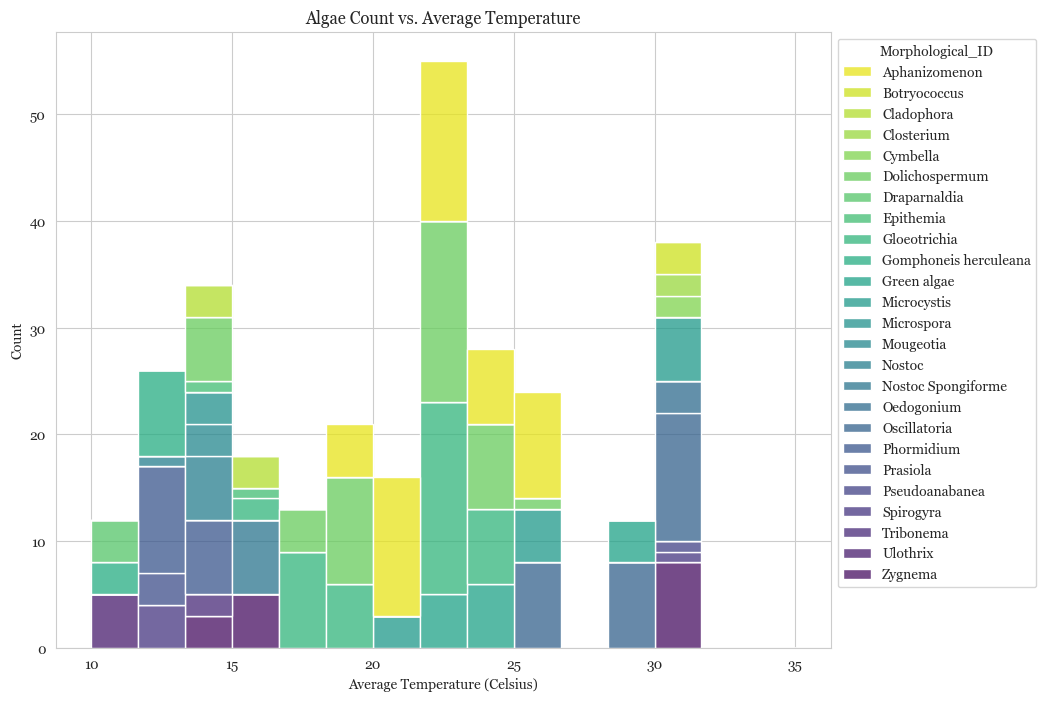

In [53]:
plt.rcParams['font.family'] = 'Georgia'                 # set font

plt.figure(figsize = (10,8))

# create stacked histogram
# algae count by morphological ID vs average temperature
ax = sns.histplot(algae_merged, x='avg_temp', hue='Morphological_ID', multiple='stack', bins=15, binrange=(10,35), palette='viridis_r')
ax.set_title('Algae Count vs. Average Temperature')
ax.set_xlabel('Average Temperature (Celsius)')

# move legend outside of graph area
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.savefig("bar.png", dpi = 1000, bbox_inches='tight')


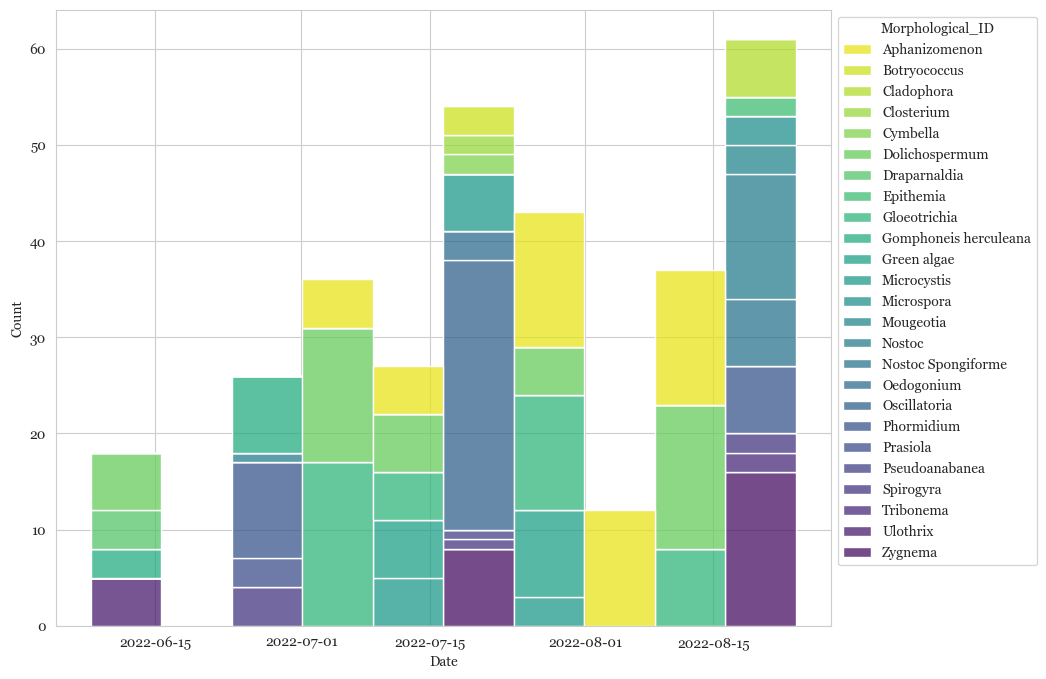

In [17]:
plt.figure(figsize = (10,8))

ax = sns.histplot(algae_merged, x='Date', hue='Morphological_ID', multiple='stack', palette='viridis_r', bins=10)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [18]:
algae_merged.describe().T

,count,mean,min,25%,50%,75%,max,std
Lat,314.0,42.140546,38.4782,39.35292,42.378403,44.146269,45.190336,2.216766
Long,314.0,-110.931203,-122.791233,-122.246272,-121.85715,-107.10744,-75.33028,17.508986
Date,314,2022-07-23 13:40:53.503184640,2022-06-08 00:00:00,2022-07-05 00:00:00,2022-07-20 00:00:00,2022-08-09 00:00:00,2022-08-24 00:00:00,NaN
Time,314,1900-01-01 11:50:45.477707008,1900-01-01 08:10:00,1900-01-01 10:05:00,1900-01-01 10:50:00,1900-01-01 13:15:00,1900-01-01 18:52:00,NaN
avg_temp,314.0,20.370955,9.9,14.475,21.505,24.8,31.18,6.348483


In [19]:
algae_merged['Morphological_ID'].unique()

array(['Aphanizomenon', 'Botryococcus', 'Cladophora', 'Closterium',
       'Cymbella', 'Dolichospermum', 'Draparnaldia', 'Epithemia',
       'Gloeotrichia', 'Gomphoneis herculeana', 'Green algae',
       'Microcystis', 'Microspora', 'Mougeotia', 'Nostoc',
       'Nostoc Spongiforme', 'Oedogonium', 'Oscillatoria', 'Phormidium',
       'Prasiola', 'Pseudoanabanea', 'Spirogyra', 'Tribonema', 'Ulothrix',
       'Zygnema'], dtype=object)

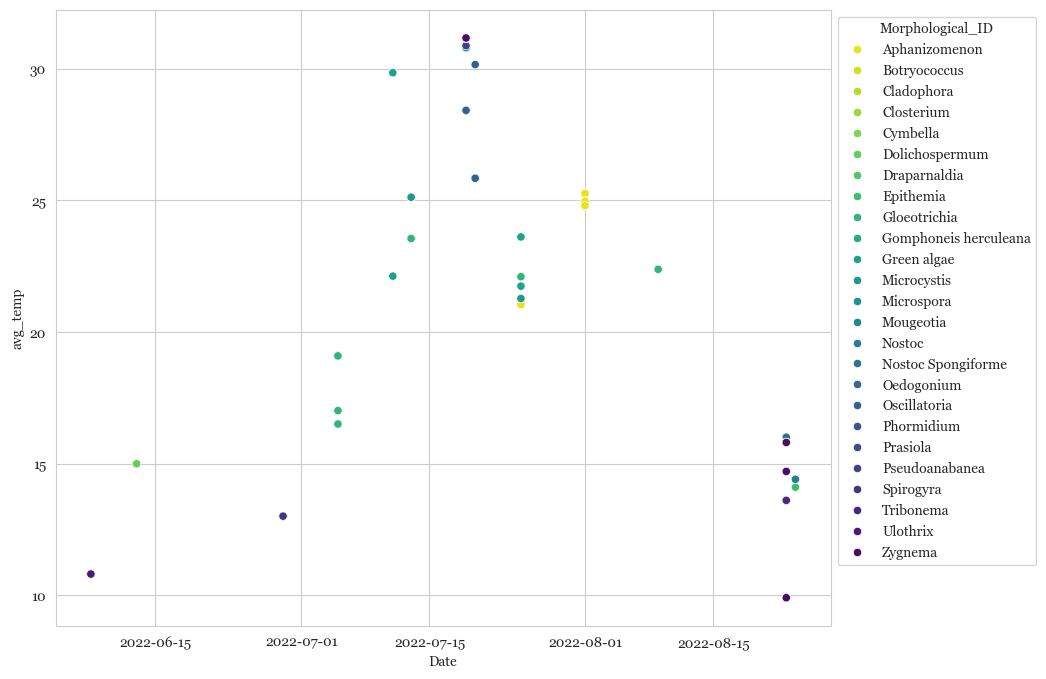

In [20]:
plt.figure(figsize = (10,8))
ax = sns.scatterplot(algae_merged, x='Date', y='avg_temp', hue='Morphological_ID', palette='viridis_r')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))



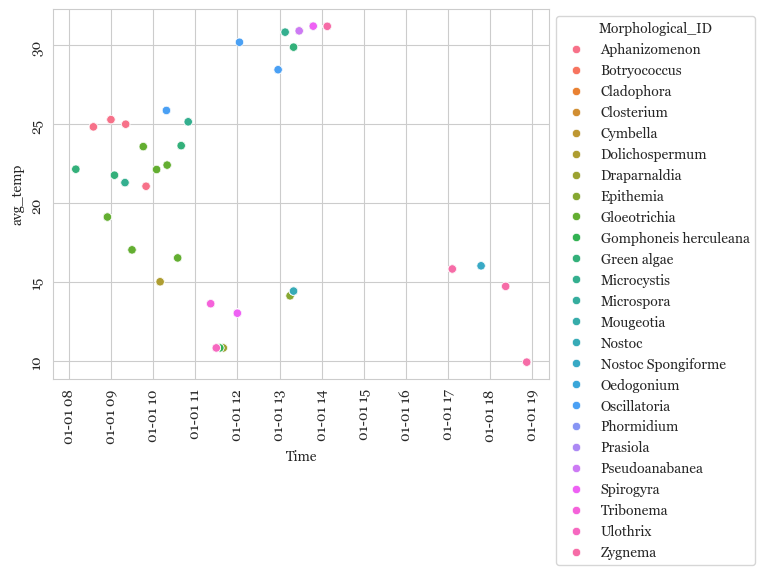

In [21]:
ax = sns.scatterplot(data=algae_merged, x='Time', y='avg_temp', hue='Morphological_ID')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.tick_params(rotation=90)



Text(0, 0.5, 'Average Temperature (Celsius)')

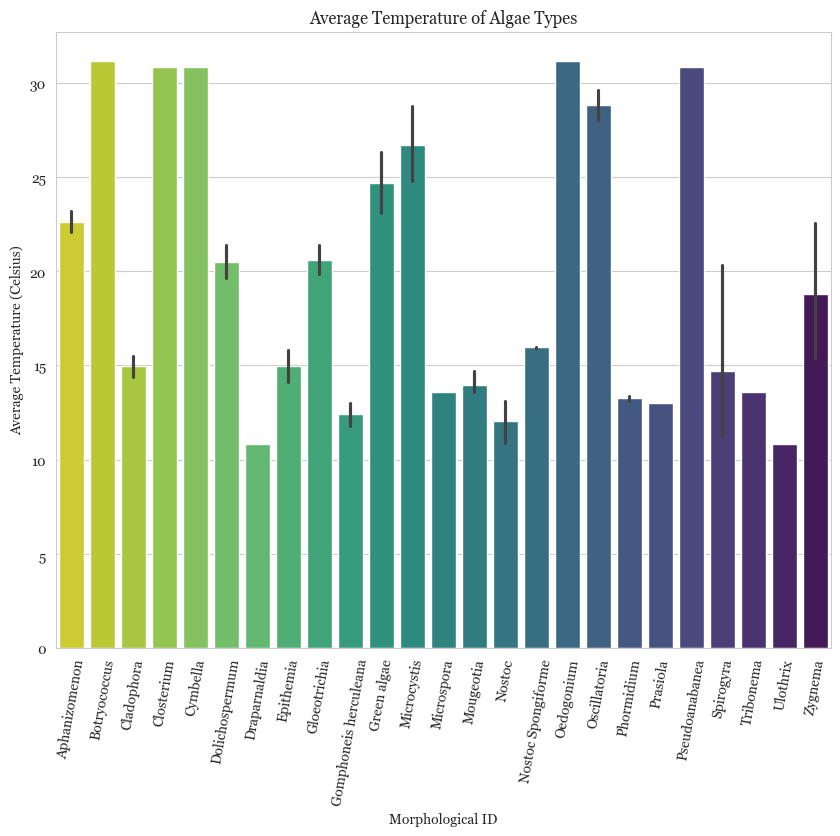

In [22]:

plt.figure(figsize = (10,8))

ax2 = sns.barplot(algae_merged, x='Morphological_ID', y='avg_temp', hue='Morphological_ID', palette='viridis_r')
ax2.tick_params(axis='x', labelrotation=80)
ax2.set_title('Average Temperature of Algae Types')
ax2.set_xlabel('Morphological ID')
ax2.set_ylabel('Average Temperature (Celsius)')

In [40]:
algae_cleaned = algae_cleaned.sort_values(by='harmful', ascending=False)

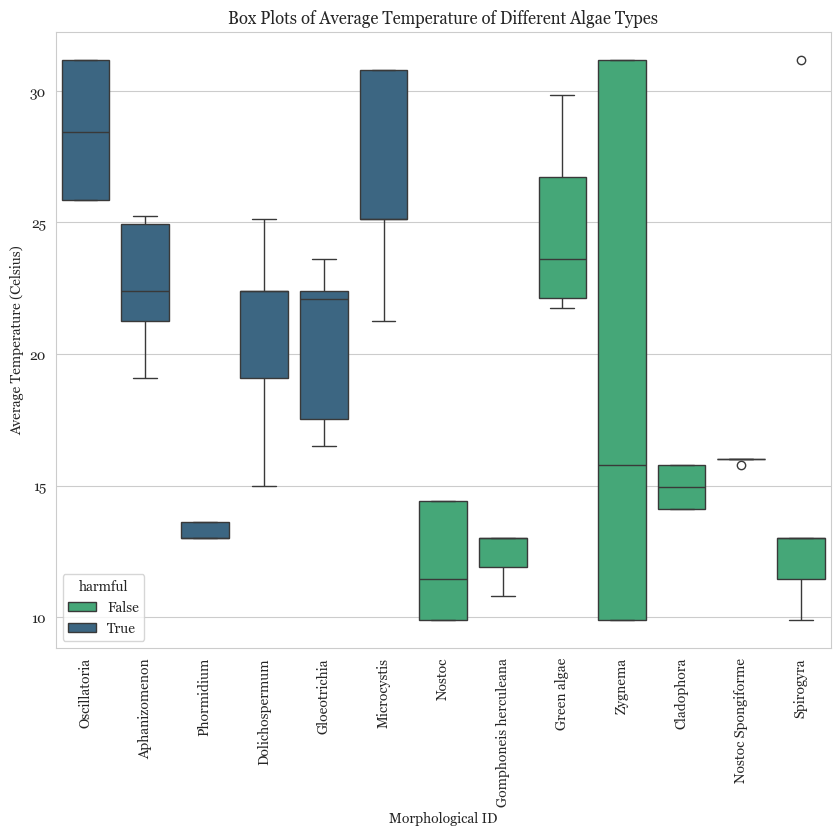

In [49]:
plt.figure(figsize = (10,8))

ax3 = sns.boxplot(data=algae_cleaned, x='Morphological_ID', y='avg_temp', hue='harmful', palette='viridis_r')
ax3.tick_params(axis='x', labelrotation=90)
ax3.set_title('Box Plots of Average Temperature of Different Algae Types')
ax3.set_xlabel('Morphological ID')
ax3.set_ylabel('Average Temperature (Celsius)')
plt.savefig("box.png", dpi = 1000, bbox_inches='tight')

plt.show()


In [24]:
algae_cleaned[algae_cleaned['Morphological_ID'] == 'Spirogyra']

,Sample_ID,Morphological_ID,Lat,Long,Date,Time,avg_temp,harmful
161,LT_P5,Spirogyra,39.353910,-77.934400,2022-07-19,1900-01-01 13:48:00,31.18,False
227,GP_Spiro,Spirogyra,44.146269,-121.411217,2022-06-29,1900-01-01 12:00:00,13.00,False
228,GP_Spiro,Spirogyra,44.146269,-121.411217,2022-06-29,1900-01-01 12:00:00,13.00,False
229,GP_Spiro,Spirogyra,44.146269,-121.411217,2022-06-29,1900-01-01 12:00:00,13.00,False
298,FB_F,Spirogyra,44.205428,-122.040147,2022-08-23,1900-01-01 18:52:00,9.90,False
294,FB_F,Spirogyra,44.205428,-122.040147,2022-08-23,1900-01-01 18:52:00,9.90,False
230,GP_Spiro,Spirogyra,44.146269,-121.411217,2022-06-29,1900-01-01 12:00:00,13.00,False


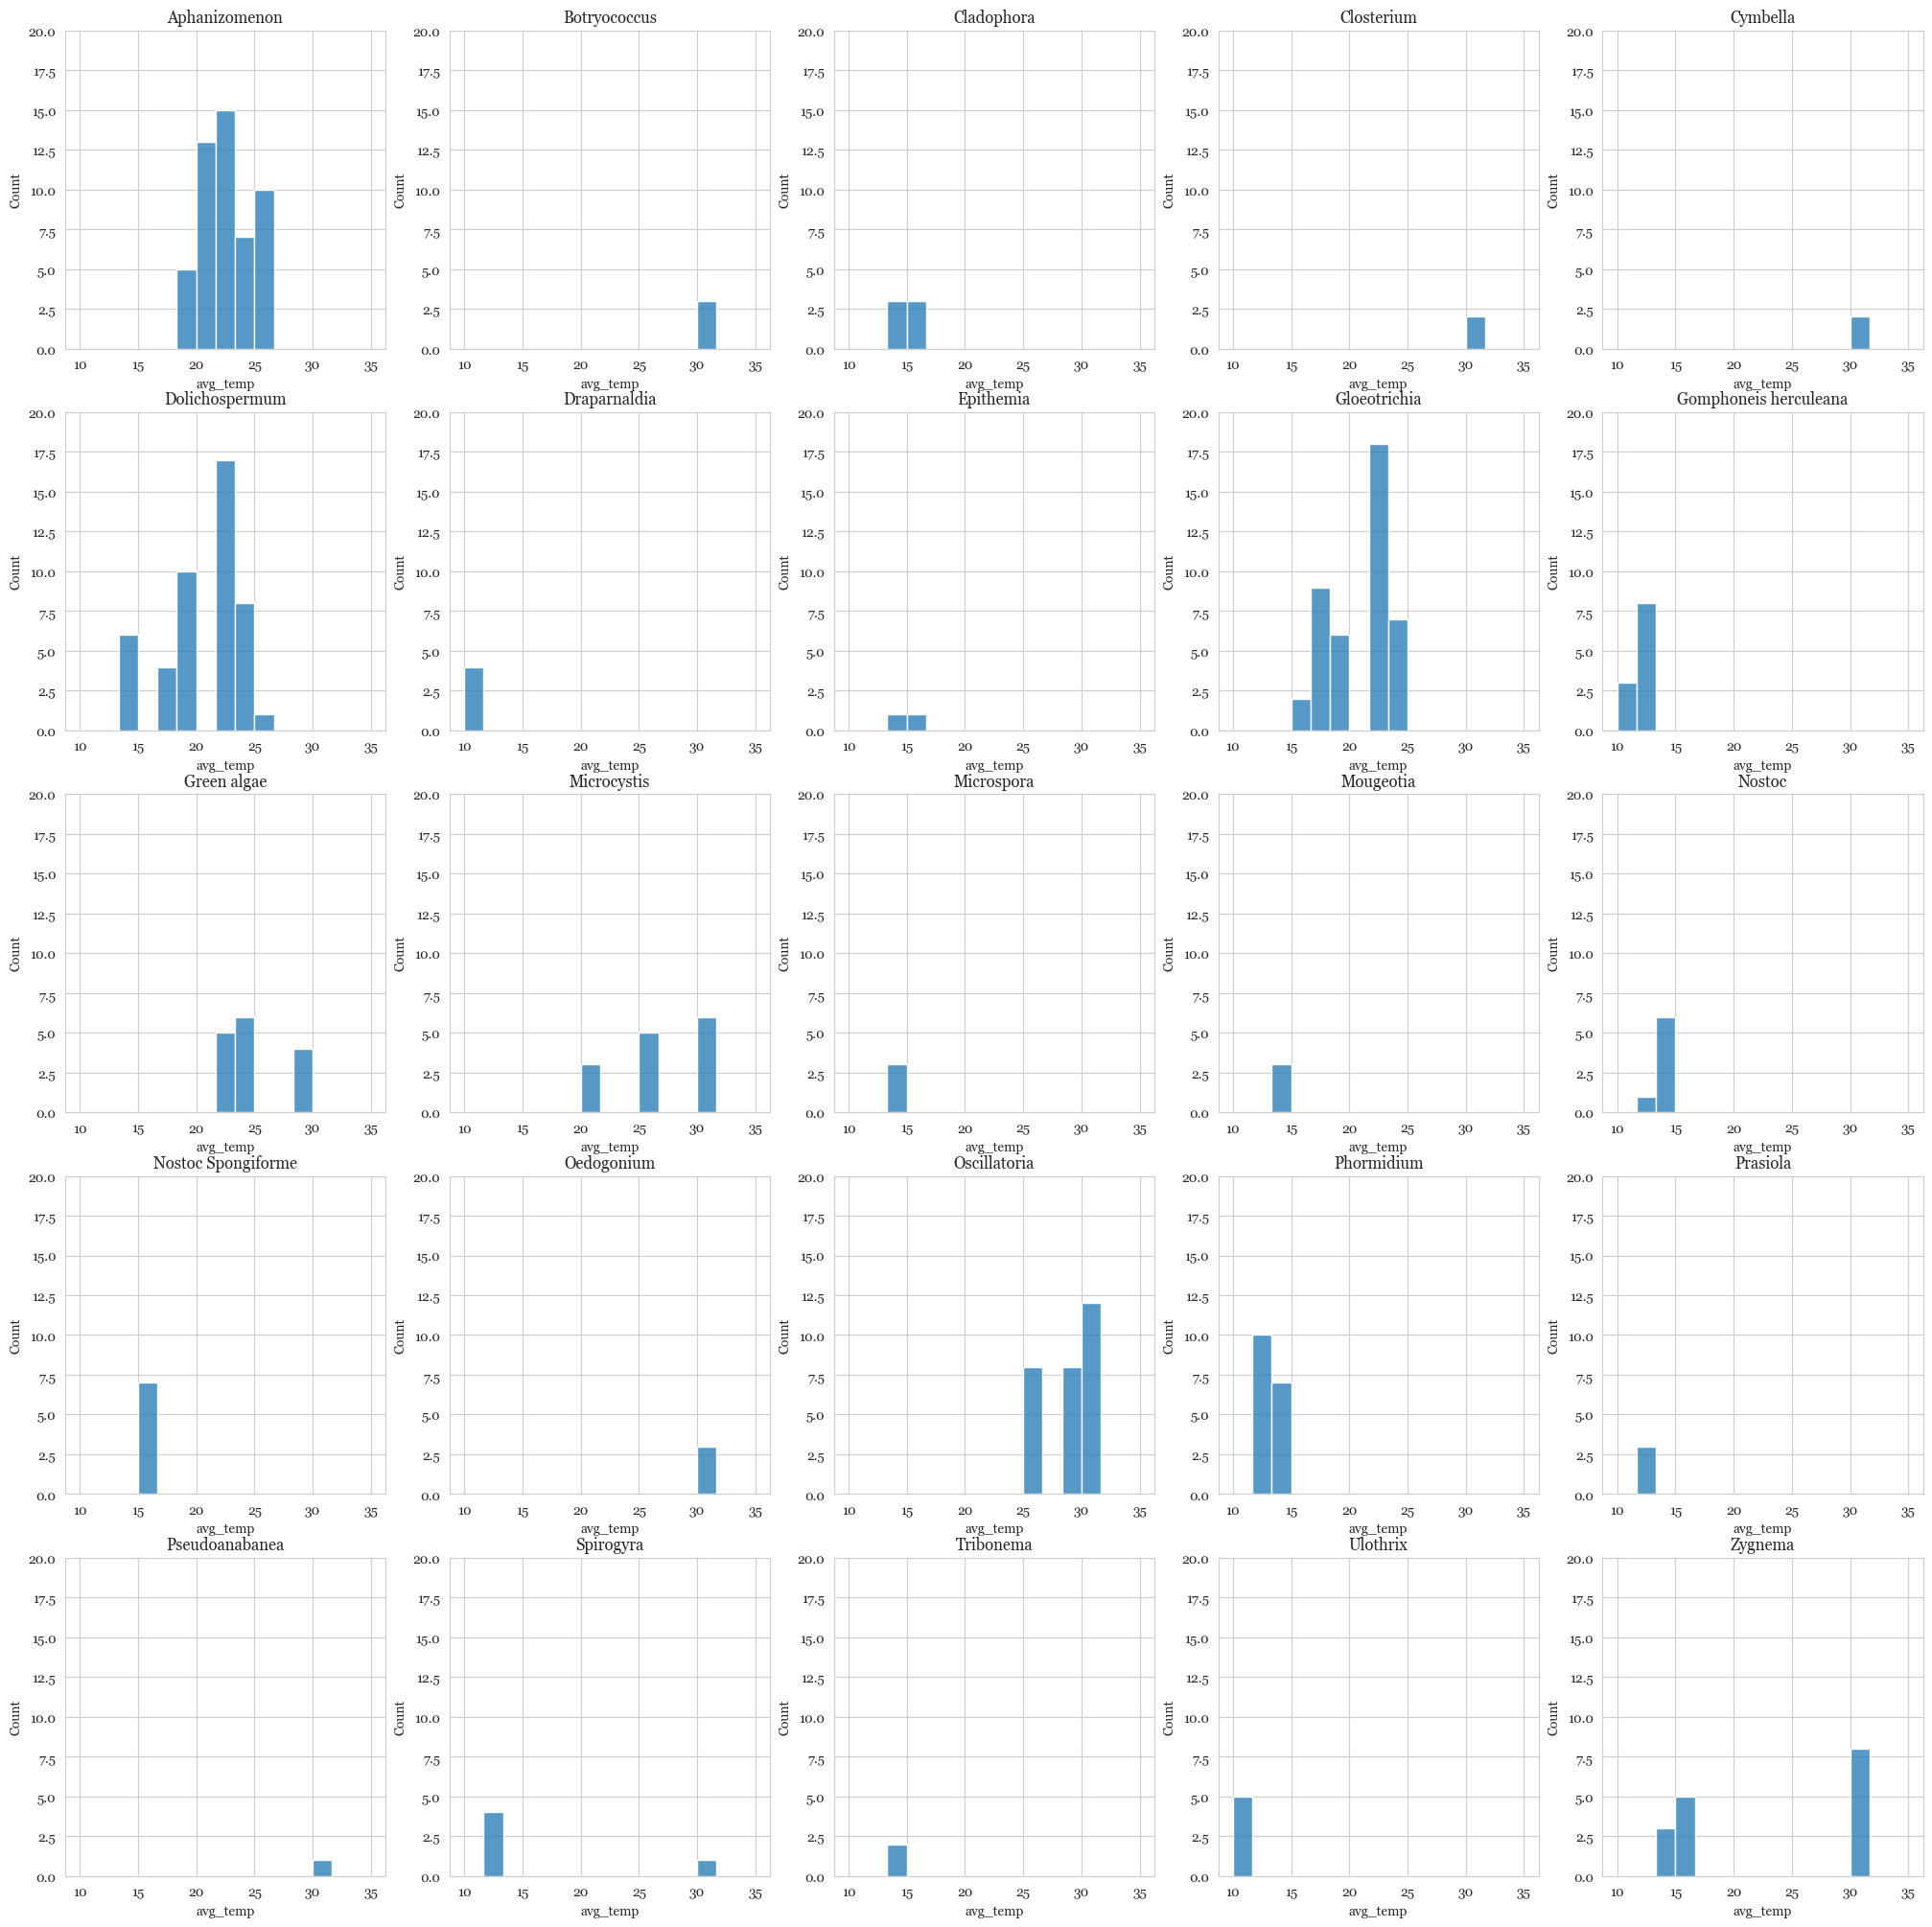

In [25]:
fig, axs = plt.subplots(5, 5, figsize = (25, 25))
row, col = 0, 0
plt.ylim(0, 20.0)
for algae in algae_merged['Morphological_ID'].unique():
    sns.histplot(algae_merged[algae_merged['Morphological_ID'] == algae], x='avg_temp', bins=15, binrange=(10,35), ax=axs[row, col])
    axs[row, col].set_title(algae)
    if row < 5:
        if col < 4:
            col += 1
        else:
            col = 0
            row += 1

for ax in axs.ravel():
    ax.set_ylim(0,20)

In [26]:
algae_merged.to_csv("algae_merged.csv")

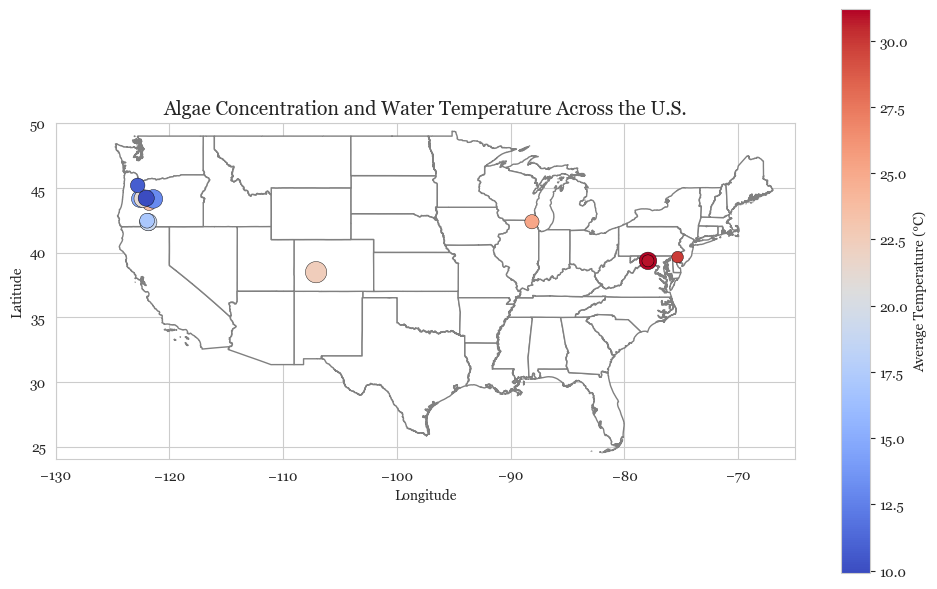

In [48]:
import geopandas as gpd

agg_df = algae_merged.groupby(["Lat", "Long"], as_index=False).agg(
    concentration=("Sample_ID", "count"),
    avg_temp=("avg_temp", "mean")
)

usa = gpd.read_file("cb_2018_us_state_500k.shp")
# oregon = usa[usa['NAME']=='Oregon']

fig, ax = plt.subplots(figsize=(10, 6))
usa.plot(ax=ax, color="white", edgecolor="gray")



sc = ax.scatter(
    agg_df["Long"],
    agg_df["Lat"],
    c=agg_df["avg_temp"],
    cmap="coolwarm",
    s=50 + agg_df["concentration"] * 5,
    edgecolor="black",
    linewidth=0.3
)

cbar = plt.colorbar(sc, ax=ax, label="Average Temperature (°C)")
ax.set_title("Algae Concentration and Water Temperature Across the U.S.", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.set_xlim(-130, -65)
ax.set_ylim(24, 50)

plt.tight_layout()
# plt.show()

plt.savefig("map.png", dpi = 1000, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

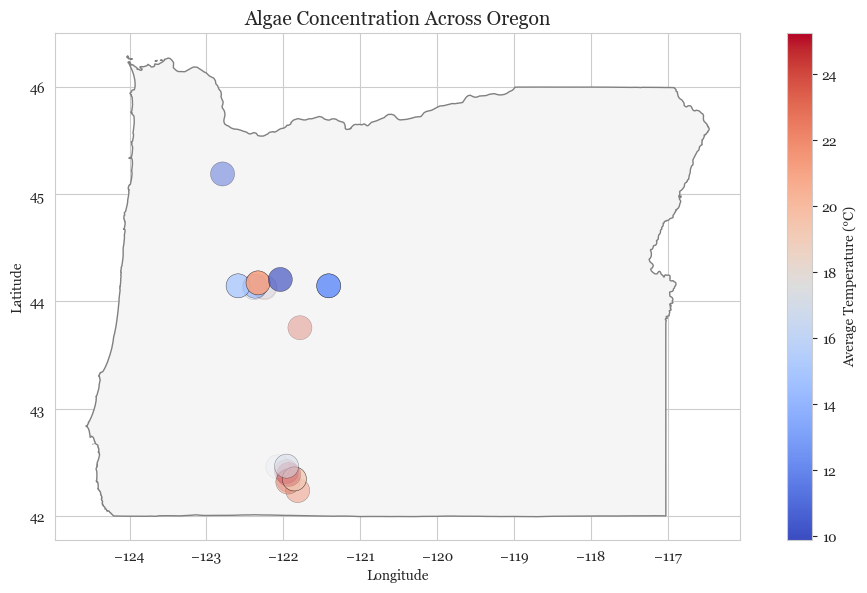

In [28]:
# focus on Oregon
oregon = usa[usa['NAME']=='Oregon']
oregon_df = agg_df[agg_df['Long'] < -120]

fig, ax = plt.subplots(figsize=(10, 6))
oregon.plot(ax=ax, color="whitesmoke", edgecolor="gray")

alpha_values = (oregon_df["concentration"] - oregon_df["concentration"].min()) / (
    oregon_df["concentration"].max() - oregon_df["concentration"].min()
) * 0.9 + 0.1

sc = ax.scatter(
    oregon_df["Long"],
    oregon_df["Lat"],
    c=oregon_df["avg_temp"],
    cmap="coolwarm",
    s=300,
    alpha=alpha_values,
    edgecolor="black",
    linewidth=0.3
)

cbar = plt.colorbar(sc, ax=ax, label="Average Temperature (°C)")
ax.set_title("Algae Concentration Across Oregon", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

In [29]:
usa.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00256 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.6432 38.16909, -82.643 38.16956,..."


In [30]:
usa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   56 non-null     object  
 1   STATENS   56 non-null     object  
 2   AFFGEOID  56 non-null     object  
 3   GEOID     56 non-null     object  
 4   STUSPS    56 non-null     object  
 5   NAME      56 non-null     object  
 6   LSAD      56 non-null     object  
 7   ALAND     56 non-null     int64   
 8   AWATER    56 non-null     int64   
 9   geometry  56 non-null     geometry
dtypes: geometry(1), int64(2), object(7)
memory usage: 4.5+ KB


In [31]:
usa['NAME'].unique()

array(['Mississippi', 'North Carolina', 'Oklahoma', 'Virginia',
       'West Virginia', 'Louisiana', 'Michigan', 'Massachusetts', 'Idaho',
       'Florida', 'Nebraska', 'Washington', 'New Mexico', 'Puerto Rico',
       'South Dakota', 'Texas', 'California', 'Alabama', 'Georgia',
       'Pennsylvania', 'Missouri', 'Colorado', 'Utah', 'Tennessee',
       'Wyoming', 'New York', 'Kansas', 'Alaska', 'Nevada', 'Illinois',
       'Vermont', 'Montana', 'Iowa', 'South Carolina', 'New Hampshire',
       'Arizona', 'District of Columbia', 'American Samoa',
       'United States Virgin Islands', 'New Jersey', 'Maryland', 'Maine',
       'Hawaii', 'Delaware', 'Guam',
       'Commonwealth of the Northern Mariana Islands', 'Rhode Island',
       'Kentucky', 'Ohio', 'Wisconsin', 'Oregon', 'North Dakota',
       'Arkansas', 'Indiana', 'Minnesota', 'Connecticut'], dtype=object)

In [32]:
agg_df.head(10)

,Lat,Long,concentration,avg_temp
0,38.478200,-107.107440,37,22.38
1,39.349670,-77.928600,1,30.16
2,39.350870,-77.926400,8,25.84
3,39.350970,-77.935700,8,28.42
4,39.351690,-77.935500,6,30.80
5,39.352920,-77.934500,22,31.17
6,39.353910,-77.934400,4,31.18
7,39.354000,-77.935100,5,30.88
8,39.644150,-75.330280,4,29.85
9,42.235901,-121.813987,11,22.10


In [33]:
algae_merged[algae_merged['Long'] > -80]

,Sample_ID,Morphological_ID,Lat,Long,Date,Time,avg_temp,harmful
214,LT_URSP,Botryococcus,39.35292,-77.93450,2022-07-19,1900-01-01 14:08:00,31.17,False
213,LT_URSP,Botryococcus,39.35292,-77.93450,2022-07-19,1900-01-01 14:08:00,31.17,False
212,LT_URSP,Botryococcus,39.35292,-77.93450,2022-07-19,1900-01-01 14:08:00,31.17,False
166,LT_P8,Closterium,39.35400,-77.93510,2022-07-19,1900-01-01 13:28:00,30.88,False
165,LT_P8,Closterium,39.35400,-77.93510,2022-07-19,1900-01-01 13:28:00,30.88,False
167,LT_P8,Cymbella,39.35400,-77.93510,2022-07-19,1900-01-01 13:28:00,30.88,False
168,LT_P8,Cymbella,39.35400,-77.93510,2022-07-19,1900-01-01 13:28:00,30.88,False
113,Salem,Green algae,39.64415,-75.33028,2022-07-11,1900-01-01 13:20:00,29.85,False
114,Salem,Green algae,39.64415,-75.33028,2022-07-11,1900-01-01 13:20:00,29.85,False
115,Salem,Green algae,39.64415,-75.33028,2022-07-11,1900-01-01 13:20:00,29.85,False


In [34]:
from scipy.stats import chi2_contingency

In [36]:
for i in range(len(algae_merged['avg_temp'])):
    if 17 <= algae_merged['avg_temp'][i] <= 27:
        algae_merged['temp_range'][i] = 'moderate'
    elif algae_merged['avg_temp'][i] < 17:
        algae_merged['temp_range'][i] = 'low'
    else:
        algae_merged['temp_range'][i] = 'high'


KeyError: 'temp_range'

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [43]:
algae_merged.head()

,Sample_ID,Morphological_ID,Lat,Long,Date,Time,avg_temp,harmful,temp_range
61,RPT_02,Aphanizomenon,42.344304,-121.858196,2022-07-25,1900-01-01 09:50:00,21.04,True,moderate
101,LL,Aphanizomenon,42.378403,-88.133460,2022-07-13,1900-01-01 10:50:00,25.12,True,moderate
36,HB_01,Aphanizomenon,42.315390,-121.941946,2022-07-25,1900-01-01 09:20:00,21.27,True,moderate
37,HB_01,Aphanizomenon,42.315390,-121.941946,2022-07-25,1900-01-01 09:20:00,21.27,True,moderate
39,HB_01,Aphanizomenon,42.315390,-121.941946,2022-07-25,1900-01-01 09:20:00,21.27,True,moderate


In [37]:
contingency = pd.crosstab(algae_merged['harmful'], algae_merged['temp_range'])

KeyError: 'temp_range'

In [45]:
contingency

temp_range,high,low,moderate
harmful,,,
False,24,82,11
True,26,25,146


In [46]:
chi2_contingency(contingency)

Chi2ContingencyResult(statistic=np.float64(134.9017803355144), pvalue=np.float64(5.086869551781773e-30), dof=2, expected_freq=array([[18.63057325, 39.86942675, 58.5       ],
       [31.36942675, 67.13057325, 98.5       ]]))